Bayesian GPLVM with full rank covariance
--
This notebook shows the difference between a full rank and a diagonal variational distribution over the latent values.

In [45]:
import GPflow
from GPflow import ekernels
from GPflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
np.random.seed(42)
GPflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

### Data
Install the oil dataset.

In [46]:
data = pods.datasets.oil_100()
Y = data['X']
print('Number of points X Number of dimensions', Y.shape)
data['citation']

Number of points X Number of dimensions (100, 12)


'Bishop, C. M. and G. D. James (1993). Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research A327, 580-593'

### Model construction
Create Bayesian GPLVM model using additive kernel.

In [47]:
Q = 3
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = GPflow.gplvm.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]
kerngen = lambda: ekernels.RBF(Q, ARD=True)

In [48]:
mdiag = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean.copy(), X_std=0.1**0.5*np.ones((N, Q)), Y=Y,
                                kern=kerngen(), M=M, Z=Z.copy())
mdiag.likelihood.variance = 0.01
mdiag.optimize(disp=True, maxiter=100)

      fun: array([-232.36464641])
 hess_inv: <665x665 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.36011973e-02,  -8.06139008e-03,  -4.63796089e-02,
         7.94683111e-03,  -4.20188711e-02,   9.95079195e-03,
         1.75470521e-03,   3.95390857e-03,   4.19510186e-02,
         1.48104823e-03,  -3.20130589e-02,   1.69271856e-02,
         1.19701582e-02,   1.91070070e-02,   1.82537106e-02,
         2.53951500e-02,   1.89875769e-02,   3.36808279e-02,
         1.75451081e-02,   8.48382705e-03,   4.97927335e-02,
         3.54692066e-04,   1.72238238e-02,   3.93105097e-02,
        -2.42259052e-03,   2.57058270e-02,  -1.33499303e-02,
         3.62706535e-02,   4.11072746e-02,   9.94497642e-02,
         2.09844284e-02,  -1.35393258e-02,   3.96368704e-02,
         1.33738031e-02,   1.43245392e-03,   4.99017006e-02,
         1.36350766e-02,   9.31115022e-03,   1.09036025e-02,
         1.24666550e-02,  -1.08164675e-02,   5.42165583e-02,
         7.16283143e-03,   1.53226408e-02

In [49]:
X_std_full = np.array([0.1**0.5*np.eye(Q) for _ in range(N)])
mfull = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean.copy(), X_std=X_std_full, Y=Y,
                                kern=kerngen(), M=M, Z=Z.copy())
mfull.likelihood.variance = 0.01
mfull.optimize(disp=True, maxiter=100)

      fun: array([-274.08714642])
 hess_inv: <1265x1265 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.23593582,  0.88789141,  0.01112954, ..., -0.23597071,
       -0.69765161,  0.32303162])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 104
      nit: 101
   status: 1
  success: False
        x: array([-3.06596547, -1.16200819,  1.5209044 , ...,  0.58796605,
       -1.51688434, -0.50433332])

In [50]:
print(mdiag.kern)

kern.lengthscales transform:+ve prior:None
[ 4.43300402  1.53250504  3.26838252]
kern.variance transform:+ve prior:None
[ 0.905609]


In [51]:
print(mfull.kern)

kern.variance transform:+ve prior:None
[ 1.63288283]
kern.lengthscales transform:+ve prior:None
[ 5.6350934   1.13646753  4.27809257]


### Compute and sensitivity to input
Sensitivity is a measure of the importance of each latent dimension. 

[ 0.21467044  0.62096691  0.29116387]
[ 0.22676519  1.12439907  0.29869457]


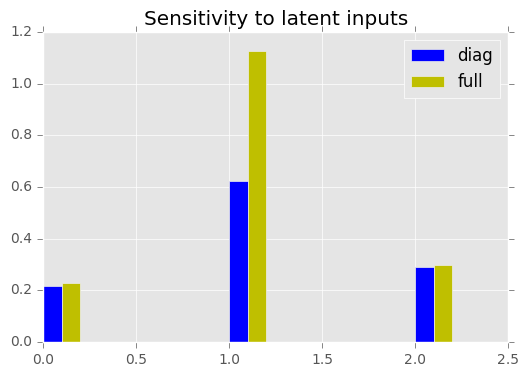

In [52]:
colours = ['b', 'y']
labels = ['diag', 'full']
inputIndices = list()
for i, m in enumerate([mdiag, mfull]):
    kern = m.kern
    sens = np.sqrt(kern.variance.value)/kern.lengthscales.value
    inputIndices.append(np.argsort(sens)[::-1][:2])
    print(sens)
    #fig, ax = plt.subplots()
    plt.bar(np.arange(len(kern.lengthscales.value)) + 0.1 * i , sens, 0.1, color=colours[i], label=labels[i])
    plt.legend()
    plt.title('Sensitivity to latent inputs')

In [53]:
inputIndices

[array([1, 2]), array([1, 2])]

### Plotting vs PCA
We see that using the 2 more relevant dimensions, the Bayesian GPLVM is able to seperate the
three classes while PCA cannot.

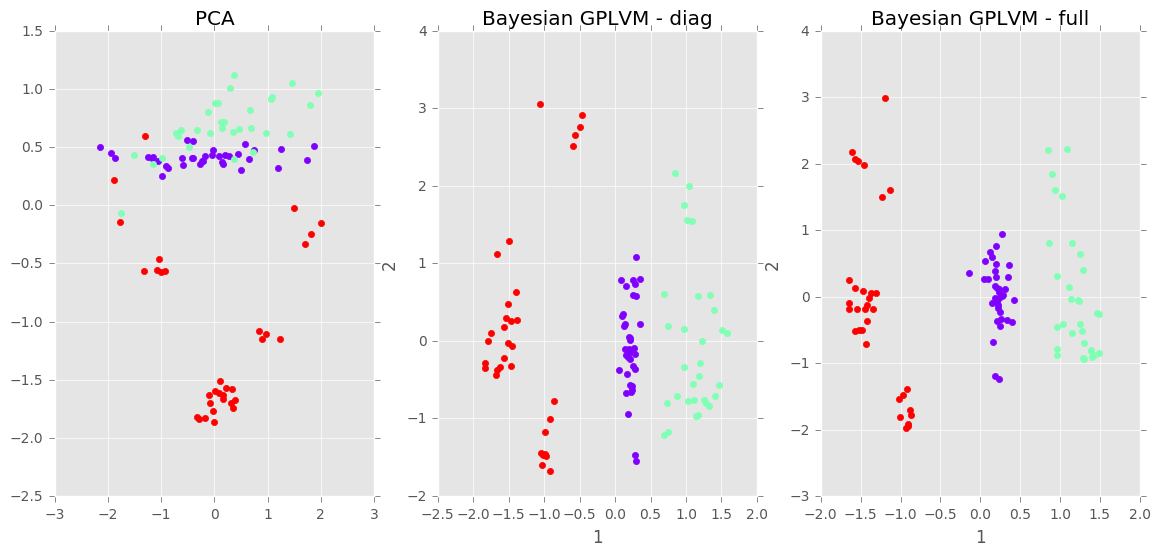

In [54]:
XPCAplot = GPflow.gplvm.PCA_reduce(data['X'], 2)
f, ax = plt.subplots(1,3, figsize=(14,6))
labels=data['Y'].argmax(axis=1)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

ax[0].set_title('PCA')
ax[1].set_xlabel(inputIndices[0][0]); ax[1].set_ylabel(inputIndices[0][1])
ax[1].set_title('Bayesian GPLVM - diag')
ax[2].set_xlabel(inputIndices[1][0]); ax[2].set_ylabel(inputIndices[1][1])
ax[2].set_title('Bayesian GPLVM - full')
for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i,0], XPCAplot[labels==i,1], color=c, label=i)
    ax[1].scatter(mdiag.X_mean.value[labels==i,inputIndices[0][0]],
                  mdiag.X_mean.value[labels==i,inputIndices[0][1]], color=c, label=i)
    ax[2].scatter(mfull.X_mean.value[labels==i,inputIndices[1][0]], 
                  mfull.X_mean.value[labels==i,inputIndices[1][1]], color=c, label=i)